# HW 4 




# Task 4.1: 

# Handwritten Digits Classification

## Overview
Implementing a Neural Network for classifying handwritten digits using the 3D MNIST dataset, with a focus on PyTorch for model development and accuracy assessment.

### Dataset
- Utilize the [3D MNIST dataset from Kaggle](https://www.kaggle.com/datasets/daavoo/3d-mnist) for training and testing the model.

### Neural Network Implementation with PyTorch
- Implement a Neural Network using PyTorch. 
- Ensure the network is suitable for handling the 3D data structure of the dataset.
- Tailor the architecture to effectively learn from the dataset for digit classification.

### Accuracy Calculation
- After training, evaluate the model on a test set.
- Calculate the accuracy of the model: $$\frac{\text{Number of Correct Predictions}}{\text{Total Predictions}}$$
- Document the model's performance and any insights gained during the development process.

In [1]:
import os 
import torch
import torch.nn as nn
import h5py
import numpy as np
import matplotlib.pyplot as plt
import torchinfo
from tqdm.auto import tqdm
from torchvision.transforms import v2
from torch.utils.data import DataLoader, TensorDataset

c:\Users\Sanya\kapitonnov_nn_n00b\neural_n00b\nn_n00b_env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
with h5py.File('data/3d_mnist/full_dataset_vectors.h5', 'r') as file:
    datasets_names = list(file.keys())
    print(datasets_names)
    X_train, y_train, X_test, y_test = file['X_train'][:], file['y_train'][:], file['X_test'][:], file['y_test'][:]

['X_test', 'X_train', 'y_test', 'y_train']


In [3]:
# Take a look at data
X_train, y_train

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([5, 5, 0, ..., 1, 2, 2], dtype=int64))

In [4]:
!nvidia-smi

Mon Dec 11 16:52:17 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.29                 Driver Version: 546.29       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1050 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              N/A / ERR! |     60MiB /  4096MiB |     18%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [5]:
# Set device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [6]:
if torch.cuda.is_available():
    # Print the number of available GPUs
    print(torch.cuda.device_count())
    # Print the current GPU device
    print(torch.cuda.current_device())
    # Print the name of the GPU
    print(torch.cuda.get_device_name(0))
else:
    print("CUDA is not available. Check your GPU drivers and CUDA installation.")

1
0
NVIDIA GeForce GTX 1050 Ti


In [7]:
# Shapes
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10000, 4096), (2000, 4096), (10000,), (2000,))

In [8]:
# Add color channels to pics
s_m = plt.cm.ScalarMappable()
X_train = s_m.to_rgba(X_train)[:,:,:-1]
X_test = s_m.to_rgba(X_test)[:,:,:-1]
print(f'X_train shape: {X_train.shape}')
print(f'X_test shape: {X_test.shape}')

X_train shape: (10000, 4096, 3)
X_test shape: (2000, 4096, 3)


In [9]:
# View observation
X_train[0]

array([[0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       ...,
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415],
       [0.267004, 0.004874, 0.329415]])

In [10]:
# Reshape 
class ReshapeT:
    def __init__(self, shape):
        self.shape = shape
        
    def __call__(self, x):
        return torch.tensor(x.reshape(self.shape))

In [11]:
# Transforms 
transformer = v2.Compose([
    v2.ToDtype(torch.float32, scale=True),
    ReshapeT((3, 16, 16, 16))
])

label_transformer = v2.Compose([
    v2.ToDtype(torch.float32, scale=False)
])

# # Custom Dataset
# class CustomDataset(Dataset):
#     def __init__(self, data, labels, transform=False, label_transform=False):
#         self.data = data
#         self.labels = labels
#         self.transform = transform
#         self.label_transform = label_transform
        
#     def __len__(self):
#         return len(self.labels)
    
#     def __getitem__(self, idx):
#         image = self.data[idx]
#         label = self.labels[idx]
#         if self.transform:
#             image = self.transform(image)
#         if self.label_transform:
#             label = self.label_transform(label)
#         return torch.Tensor(image), torch.tensor(label)

In [12]:
# Preprocess data
X_train = torch.tensor(X_train.reshape((len(X_train), 3, 16, 16, 16)), dtype=torch.float32).to(device)
X_test = torch.tensor(X_test.reshape((len(X_test), 3, 16, 16, 16)), dtype=torch.float32).to(device)
y_train = torch.tensor(y_train).to(device)
y_test = torch.tensor(y_test).to(device)

In [13]:
# Hyperparameters
BATCH_SIZE = 64
NUM_WORKERS = os.cpu_count()

# Datasets
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS, shuffle=False)

In [14]:
# View dataset item
train_dataset[0]

(tensor([[[[0.2670, 0.0049, 0.3294,  ..., 0.0049, 0.3294, 0.5756],
           [0.8446, 0.2564, 0.5756,  ..., 0.2564, 0.5756, 0.8446],
           [0.2564, 0.2670, 0.0049,  ..., 0.2670, 0.0049, 0.3294],
           ...,
           [0.7740, 0.4066, 0.1312,  ..., 0.5525, 0.3278, 0.7740],
           [0.4066, 0.2670, 0.0049,  ..., 0.2670, 0.0049, 0.3294],
           [0.2670, 0.0049, 0.3294,  ..., 0.0049, 0.3294, 0.1579]],
 
          [[0.6838, 0.5017, 0.1563,  ..., 0.5579, 0.1579, 0.6838],
           [0.5017, 0.2670, 0.0049,  ..., 0.2670, 0.0049, 0.3294],
           [0.2670, 0.0049, 0.3294,  ..., 0.0049, 0.3294, 0.1579],
           ...,
           [0.3294, 0.2670, 0.0049,  ..., 0.2670, 0.0049, 0.3294],
           [0.2670, 0.0049, 0.3294,  ..., 0.0049, 0.3294, 0.2670],
           [0.0049, 0.3294, 0.2670,  ..., 0.3294, 0.2670, 0.0049]],
 
          [[0.3294, 0.2670, 0.0049,  ..., 0.2670, 0.0049, 0.3294],
           [0.2670, 0.0049, 0.3294,  ..., 0.0049, 0.3294, 0.2670],
           [0.0049, 0.32

In [15]:
# Take a look at sample
# next(iter(train_dataloader))

In [16]:
# NN architecture
class Convolutional_3d(nn.Module):
    def __init__(self, input_layers, hidden_layers, output_layers, number_of_class=0):
        super(Convolutional_3d, self).__init__()
        self.conv3d_block_1 = nn.Sequential(
            nn.Conv3d(in_channels=input_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=1)
        )
        
        self.conv3d_block_2 = nn.Sequential(
            nn.Conv3d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv3d(in_channels=hidden_layers, out_channels=hidden_layers, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool3d(kernel_size=3, stride=1)
        )
        
        self.classifier_block = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=32000, out_features=1024), # 32000 a number taken from a shape error.
            nn.ReLU(),
            nn.Linear(in_features=1024, out_features=512),
            nn.ReLU(),
            nn.Linear(in_features=512, out_features=output_layers),
            nn.ReLU(),
            nn.Softmax()
        )
    
    def forward(self, x):
        return self.classifier_block(self.conv3d_block_2(self.conv3d_block_2(self.conv3d_block_1(x))))


In [17]:
model_0 = Convolutional_3d(input_layers=3,
                           hidden_layers=32,
                           output_layers=10).to(device)

In [18]:
model_0

Convolutional_3d(
  (conv3d_block_1): Sequential(
    (0): Conv3d(3, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU()
    (4): MaxPool3d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3d_block_2): Sequential(
    (0): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (1): ReLU()
    (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (3): ReLU()
    (4): MaxPool3d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier_block): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=32000, out_features=1024, bias=True)
    (2): ReLU()
    (3): Linear(in_features=1024, out_features=512, bias=True)
    (4): ReLU()
    (5): Linear(in_features=512, out_features=10, bias=True)
    (6): ReLU()
    (7): Softmax(dim=None)
  )

In [19]:
torchinfo.summary(model_0)

Layer (type:depth-idx)                   Param #
Convolutional_3d                         --
├─Sequential: 1-1                        --
│    └─Conv3d: 2-1                       2,624
│    └─ReLU: 2-2                         --
│    └─Conv3d: 2-3                       27,680
│    └─ReLU: 2-4                         --
│    └─MaxPool3d: 2-5                    --
├─Sequential: 1-2                        --
│    └─Conv3d: 2-6                       27,680
│    └─ReLU: 2-7                         --
│    └─Conv3d: 2-8                       27,680
│    └─ReLU: 2-9                         --
│    └─MaxPool3d: 2-10                   --
├─Sequential: 1-3                        --
│    └─Flatten: 2-11                     --
│    └─Linear: 2-12                      32,769,024
│    └─ReLU: 2-13                        --
│    └─Linear: 2-14                      524,800
│    └─ReLU: 2-15                        --
│    └─Linear: 2-16                      5,130
│    └─ReLU: 2-17                       

In [20]:
EPOCHS = 5
LR = 0.001
OPTIMIZER = torch.optim.Adam(params=model_0.parameters(), lr=LR)
LOSS_FUNC = nn.CrossEntropyLoss()

In [21]:
# Results dict
results = {'train_loss': [],
           'train_acc': [],
           'test_loss': [],
           'test_acc': []}

# train model
model_0.train()
print('TRAINING...')
train_loss_mean, train_acc_mean = 0, 0
train_num_batches = len(train_dataloader)
for epoch in tqdm(range(EPOCHS)):
    print(f'Epoch: {epoch}\n-------------------------------------------------------------------------------')
    for batch, (image, label) in enumerate(train_dataloader, start=1):
        logits = model_0(image)
        loss = LOSS_FUNC(logits, label)
        OPTIMIZER.zero_grad()
        loss.backward()
        OPTIMIZER.step()
        train_loss_mean += loss.item()
        train_acc_mean += (logits.argmax(1)==label).type(torch.float32).sum().item()/len(logits)
    train_loss_mean /= train_num_batches
    train_acc_mean /= train_num_batches
    print(f'Train Loss: {train_loss_mean:.4f} || Train Accuracy: {train_acc_mean:.2f}%\n')
    results['train_loss'].append(train_loss_mean)
    results['train_acc'].append(train_acc_mean)
print('Finished TRAINING!','\n')

# test model
model_0.eval()
print('\n', 'TESTING...')
test_num_batches = len(test_dataloader)
test_loss_mean, test_acc_mean = 0, 0
with torch.inference_mode():
    for image, label in test_dataloader:
        pred = model_0(image)
        loss = LOSS_FUNC(pred, label)
        test_loss_mean += loss.item()
        test_acc_mean += (pred.argmax(1)==label).type(torch.float32).sum().item()/len(pred)
test_loss_mean /= test_num_batches
test_acc_mean /= test_num_batches
print(f'Mean test Loss: {test_loss_mean:.4f} || Mean test Accuracy: {test_acc_mean:.2f}%\n')
results['test_loss'].append(test_loss_mean)
results['test_acc'].append(test_acc_mean)
print('Finished TESTING!')

TRAINING...


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------------------------------------------------------------------------------


c:\Users\Sanya\kapitonnov_nn_n00b\neural_n00b\nn_n00b_env\Lib\site-packages\torch\nn\modules\module.py:1518: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)
 20%|██        | 1/5 [00:43<02:53, 43.38s/it]

Train Loss: 2.3026 || Train Accuracy: 1.00%

Epoch: 1
-------------------------------------------------------------------------------


 40%|████      | 2/5 [01:27<02:11, 43.95s/it]

Train Loss: 2.3173 || Train Accuracy: 1.01%

Epoch: 2
-------------------------------------------------------------------------------


 60%|██████    | 3/5 [02:12<01:28, 44.21s/it]

Train Loss: 2.3173 || Train Accuracy: 1.01%

Epoch: 3
-------------------------------------------------------------------------------


 80%|████████  | 4/5 [02:57<00:44, 44.61s/it]

Train Loss: 2.3173 || Train Accuracy: 1.01%

Epoch: 4
-------------------------------------------------------------------------------


100%|██████████| 5/5 [03:43<00:00, 44.64s/it]

Train Loss: 2.3173 || Train Accuracy: 1.01%

Finished TRAINING! 


 TESTING...


Mean test Loss: 2.3026 || Mean test Accuracy: 1.00%

Finished TESTING!


In [22]:
results

{'train_loss': [2.3025848895880827,
  2.317251035381637,
  2.317344450322998,
  2.317345045322624,
  2.3173450491124306],
 'train_acc': [1.0,
  1.0063694267515924,
  1.006409996348736,
  1.0064102547538136,
  1.0064102563997057],
 'test_loss': [2.3025849014520645],
 'test_acc': [1.0]}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


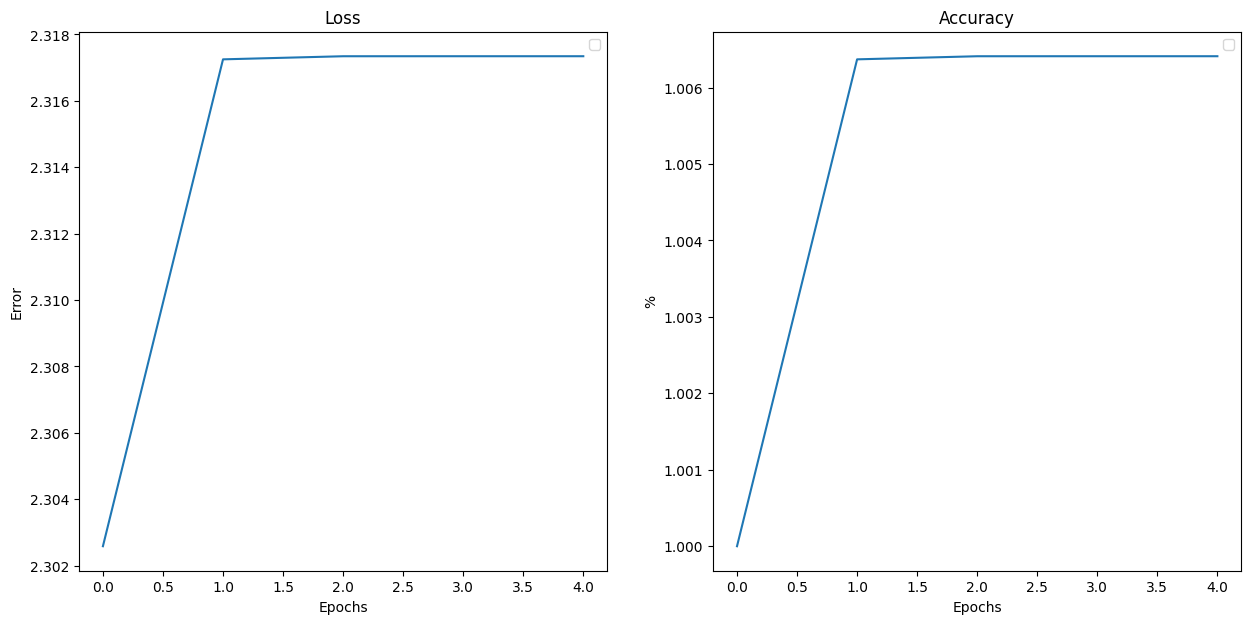

In [23]:
fig = plt.figure(figsize=(15, 7))
epochs = range(len(results['train_loss']))
plt.subplot(1,2,1)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Error')
plt.legend()
plt.plot(epochs, results['train_loss'])

plt.subplot(1,2,2)
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('%')
plt.legend()
plt.plot(epochs, results['train_acc'])